<a href="https://colab.research.google.com/github/myarist/Dicoding/blob/main/Project/Tweet%20Emotion%20Classification%20-%20NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import zipfile
import warnings
warnings.filterwarnings("ignore")

!pip install ipython-autotime
%load_ext autotime

time: 1.2 ms (started: 2021-05-17 07:47:40 +00:00)


# Extract Data
Extract and save data locally in /tmp folder

In [ ]:
local_zip = '/content/drive/MyDrive/Colab Notebooks/Data/emotion.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

time: 25.1 ms (started: 2021-05-17 07:47:40 +00:00)


# Read Data

In [ ]:
data = pd.read_csv("/tmp/Emotion_final.csv")
data.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


time: 43.5 ms (started: 2021-05-17 07:47:40 +00:00)


In [ ]:
data.shape

(21459, 2)

time: 2.95 ms (started: 2021-05-17 07:47:40 +00:00)


In [ ]:
data.Emotion.value_counts()

happy       7029
sadness     6265
anger       2993
fear        2652
love        1641
surprise     879
Name: Emotion, dtype: int64

time: 8.38 ms (started: 2021-05-17 07:47:40 +00:00)


# Make Dummy Variable for Emoticon

In [ ]:
emotion = pd.get_dummies(data.Emotion)
data_new = pd.concat([data, emotion], axis=1)
data_new = data_new.drop(columns='Emotion')
data_new.head()

,Text,anger,fear,happy,love,sadness,surprise
0,i didnt feel humiliated,0,0,0,0,1,0
1,i can go from feeling so hopeless to so damned...,0,0,0,0,1,0
2,im grabbing a minute to post i feel greedy wrong,1,0,0,0,0,0
3,i am ever feeling nostalgic about the fireplac...,0,0,0,1,0,0
4,i am feeling grouchy,1,0,0,0,0,0


time: 27 ms (started: 2021-05-17 07:47:40 +00:00)


In [ ]:
text = data_new['Text'].values
emot = data_new[['anger',	'fear',	'happy',	'love',	'sadness',	'surprise']].values

time: 3.07 ms (started: 2021-05-17 07:47:40 +00:00)


In [ ]:
text

array(['i didnt feel humiliated',
       'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
       'im grabbing a minute to post i feel greedy wrong', ...,
       'Vincent was irritated but not dismay',
       'Kendall-Hume turned back to face the dismayed coup',
       'I am dismayed , but not surpris'], dtype=object)

time: 3.8 ms (started: 2021-05-17 07:47:40 +00:00)


In [ ]:
emot

array([[0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0],
       ...,
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0]], dtype=uint8)

time: 3.26 ms (started: 2021-05-17 07:47:40 +00:00)


# Split Data

In [ ]:
text_train, text_test, emot_train, emot_test = train_test_split(text, emot, test_size=0.2, random_state=42) 

time: 4.78 ms (started: 2021-05-17 07:47:40 +00:00)


# Tokenization

In [ ]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(text_train) 
tokenizer.fit_on_texts(text_test)
 
seq_train = tokenizer.texts_to_sequences(text_train)
seq_test = tokenizer.texts_to_sequences(text_test)
 
pad_train = pad_sequences(seq_train)
pad_test = pad_sequences(seq_test)

time: 790 ms (started: 2021-05-17 07:47:40 +00:00)


# Use Callback to Control the Epoch

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,
    patience=5, 
    min_lr=1.5e-5
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=12,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True
)

time: 3.05 ms (started: 2021-05-17 07:47:41 +00:00)


# Make Some Function to Plot the Modelling History

In [ ]:
plt.style.use('seaborn-whitegrid')

def plot_acc(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  epochs = range(len(acc))
  plt.subplot(1, 2, 1)
  acc_plot, = plt.plot(epochs, acc, 'r')
  val_acc_plot, = plt.plot(epochs, val_acc, 'b')
  plt.title('Training and Validation Accuracy')
  plt.legend([acc_plot, val_acc_plot], ['Training Accuracy', 'Validation Accuracy'])


def plot_loss(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))
  plt.subplot(1, 2, 2)
  loss_plot, = plt.plot(epochs, loss, 'r')
  val_loss_plot, = plt.plot(epochs, val_loss, 'b')
  plt.title('Training and Validation Loss')
  plt.legend([loss_plot, val_loss_plot], ['Training Loss', 'Validation Loss'])

def plot_history(history):
  plt.figure(figsize=(15,5))
  plot_acc(history)
  plot_loss(history)

time: 14.9 ms (started: 2021-05-17 07:47:41 +00:00)


# Construct Basic Sequential Model Using CNN

In [ ]:
tf.keras.backend.clear_session()

model_emot = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=20000, output_dim=64),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(6, activation='softmax')
])

model_emot.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          1280000   
_________________________________________________________________
dropout (Dropout)            (None, None, 64)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
Total params: 1,313,414
Trainable params: 1,313,414
Non-trainable params: 0
_________________________________________________________________
time: 260 ms (started: 2021-05-17 08:25:24 +00:00)


# Running the Basic Model

In [ ]:
model_emot.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

history_emot = model_emot.fit(
    pad_train, 
    emot_train,
    epochs=100,
    callbacks = [reduce_lr, early_stop],
    verbose=1,
    validation_data=(pad_test, emot_test)
)

Epoch 1/100
537/537 [==============================] - 11s 18ms/step - loss: 0.4539 - accuracy: 0.3208 - val_loss: 0.3179 - val_accuracy: 0.5650
Epoch 2/100
537/537 [==============================] - 9s 17ms/step - loss: 0.2784 - accuracy: 0.6383 - val_loss: 0.1864 - val_accuracy: 0.8034
Epoch 3/100
537/537 [==============================] - 9s 17ms/step - loss: 0.1568 - accuracy: 0.8343 - val_loss: 0.1064 - val_accuracy: 0.8842
Epoch 4/100
537/537 [==============================] - 9s 17ms/step - loss: 0.0920 - accuracy: 0.9032 - val_loss: 0.0897 - val_accuracy: 0.9045
Epoch 5/100
537/537 [==============================] - 9s 17ms/step - loss: 0.0641 - accuracy: 0.9400 - val_loss: 0.0720 - val_accuracy: 0.9166
Epoch 6/100
537/537 [==============================] - 9s 17ms/step - loss: 0.0505 - accuracy: 0.9527 - val_loss: 0.0738 - val_accuracy: 0.9161
Epoch 7/100
537/537 [==============================] - 9s 17ms/step - loss: 0.0386 - accuracy: 0.9629 - val_loss: 0.0729 - val_accuracy

# Visualize the History of Basic Model

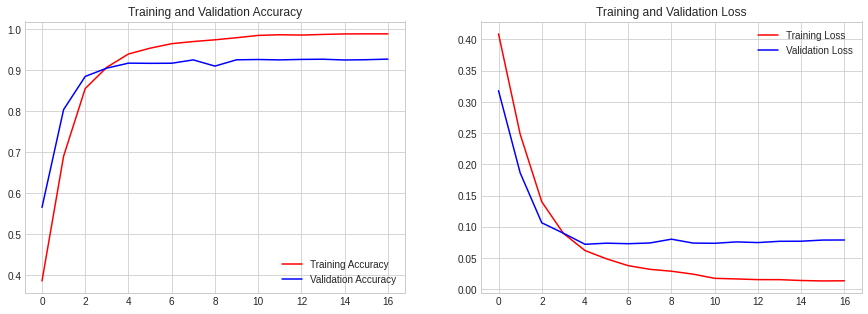

time: 367 ms (started: 2021-05-17 08:27:59 +00:00)


In [ ]:
plot_history(history_emot)

# Save the Basic Model for Deployment

In [ ]:
model_emot.save_weights('model_emot_weights.h5')
model_emot.save('model_emot.h5')

time: 64.5 ms (started: 2021-05-17 08:27:59 +00:00)


# Make Function to Predict Any Sentence

In [ ]:
def predict_emotion(sentence, model = model_emot):
  sequence = tokenizer.texts_to_sequences([sentence])
  test = pad_sequences(sequence)
  predict_array = model.predict(test)[0]

  df = pd.DataFrame(predict_array)
  df = df.rename({0:'Probability'}, axis = 'columns')
  prod = ['Anger', 'Fear', 'Happy', 'Love', 'Sadness', 'Surprise']
  df['Emotion'] = prod
  df = df[['Emotion', 'Probability']]

  predict_label = np.argmax(model.predict(test), axis=1)[0]

  if predict_label == 0:
      predict_product = 'Anger'
  elif predict_label == 1:
      predict_product = 'Fear'
  elif predict_label == 2:
      predict_product = 'Happy'
  elif predict_label == 3:
      predict_product = 'Love'
  elif predict_label == 4:
      predict_product = 'Sadness'
  else:
      predict_product = 'Surprise'

  return predict_product, df

time: 12.2 ms (started: 2021-05-17 08:28:00 +00:00)


In [ ]:
sentence = "Best regards, this is my submission"

label, df = predict_emotion(sentence)

print('"' + sentence + '"')
print("\nThe sentence is detected as " + label)
print()
print(df.sort_values(by='Probability', ascending=False))
print()

"Best regards, this is my submission"

The sentence is detected as Happy

    Emotion  Probability
2     Happy     0.353755
4   Sadness     0.179343
0     Anger     0.151928
3      Love     0.125626
5  Surprise     0.105359
1      Fear     0.083990

time: 75.3 ms (started: 2021-05-17 08:35:27 +00:00)
